In [8]:
# UBIT: 50613803 Name: Pramila Yadav

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

**DATA RETRIEVAL**
We have planned to use the dataset from Google maps, hence we have 
**Loading our Scraped Dataset which needs to be cleaned** 

In [9]:
file_path = "Data_5.csv"
df = pd.read_csv(file_path)

**DATA CLEANING**

In [10]:

df_cleaned = df.dropna(subset=['latitude', 'popular_times', 'longitude', 'rating'])

df_cleaned['city'] = df_cleaned['city'].str.lower()
df_cleaned['us_state'] = df_cleaned['us_state'].str.lower()
df_cleaned['city'] = df_cleaned['city'].str.capitalize()
df_cleaned['us_state'] = df_cleaned['us_state'].str.capitalize()

df_cleaned['working_hours'] = df_cleaned['working_hours'].astype(str)
df_cleaned['working_hours'] = df_cleaned['working_hours'].apply(lambda x: re.sub(r'[a-zA-Z\s]+', '', x))
df_cleaned['working_hours'] = df_cleaned['working_hours'].fillna('Unknown')

def get_weekday_hours(working_hours):
    try:
        parts = working_hours.split(':')
        weekday_parts = parts[1:6]
        weekday_hours = sum(1 for part in weekday_parts if part.strip())
        return weekday_hours
    except Exception as e:
        return 0 

def get_weekend_hours(working_hours):
    try:
        parts = working_hours.split(':')
        weekend_parts = parts[5:7]
        weekend_hours = sum(1 for part in weekend_parts if part.strip())
        return weekend_hours
    except Exception as e:
        return 0  

df_cleaned['weekday_hours'] = df_cleaned['working_hours'].apply(get_weekday_hours)
df_cleaned['weekend_hours'] = df_cleaned['working_hours'].apply(get_weekend_hours)

df_cleaned['name'] = df_cleaned['name'].str.title()

df_cleaned = df_cleaned[(df_cleaned['latitude'].between(-90, 90)) & (df_cleaned['longitude'].between(-180, 180))]
df_cleaned['latitude'] = df_cleaned['latitude'].round(6)
df_cleaned['longitude'] = df_cleaned['longitude'].round(6)

df_cleaned['rating_category'] = pd.cut(df_cleaned['rating'], bins=[0, 3, 4.5, 5], labels=['Low', 'Medium', 'High'])

df_cleaned['name'] = df_cleaned['name'].str.strip()
df_cleaned['city'] = df_cleaned['city'].str.strip()

def has_values_after_colon(working_hours):
    try:
        parts = working_hours.split(':')
        if len(parts) > 6 and parts[6].strip(): 
            return True 
        if len(parts) > 7 and parts[7].strip():  
            return True  
        return False
    except Exception as e:
        return False

df_cleaned['is_weekend_open'] = df_cleaned['working_hours'].apply(has_values_after_colon)

df_cleaned['rating'] = pd.to_numeric(df_cleaned['rating'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['rating'])

df_cleaned['working_hours'] = df_cleaned['working_hours'].apply(lambda x: re.sub(r'[^\d:-]', '', x))
df_cleaned['weekday_hours'] = df_cleaned['working_hours'].apply(get_weekday_hours)
df_cleaned['weekend_hours'] = df_cleaned['working_hours'].apply(get_weekend_hours)
df_cleaned['rating_scaled'] = (df_cleaned['rating'] / df_cleaned['rating'].max()) * 5
df_cleaned['popular_times'] = df_cleaned['popular_times'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_cleaned = df_cleaned[df_cleaned['popular_times'].apply(lambda x: isinstance(x, list) and len(x) == 7)]

results = []

for idx, row in df_cleaned.iterrows():
    popular_times = row['popular_times'] 
    df = pd.DataFrame(popular_times, index=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
    df.columns = [f'{hour:02d}:00' for hour in range(24)]
    
    daily_avg_popularity = df.mean(axis=1)
    busiest_hours = df.idxmax(axis=1)
    overall_avg_popularity = df.values.mean()
    weekday_popularity = df.loc['Monday':'Friday'].mean().mean()
    weekend_popularity = df.loc[['Saturday', 'Sunday']].mean().mean()
    weekday_weekend_ratio = weekday_popularity / weekend_popularity if weekend_popularity else 100  

    results.append({
        'name': row['name'],
        'daily_avg_popularity': daily_avg_popularity.tolist(),
        'busiest_hours': busiest_hours.tolist(),
        'overall_avg_popularity': overall_avg_popularity,
        'weekday_weekend_ratio': weekday_weekend_ratio
    })


results_df = pd.DataFrame(results)

df_cleaned = df_cleaned.merge(
    results_df[['name', 'daily_avg_popularity', 'busiest_hours', 'overall_avg_popularity', 'weekday_weekend_ratio']], 
    on='name'
)

print("Updated DataFrame with Popularity Metrics:")
print(df_cleaned.head())




Updated DataFrame with Popularity Metrics:
   Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0                         name  \
0             0             0           0            Mardis Mill Falls   
1             1             1           1  Waterville Usa/Escape House   
2             2             2           2    Bama Bison Rv Park & Farm   
3             3             3           3            The Mobile Tunnel   
4             4             4           4                    Bamahenge   

                                       popular_times   latitude  longitude  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  34.044364 -86.571446   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  30.258331 -87.687064   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  32.425044 -85.250269   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  30.690009 -88.035620   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  30.331442 -87.567232   

                  working_hours          ci

In [11]:
#Using SVR for latitude and longitude v/s rating for "How does the geographical location (latitude/longitude) relate to customer ratings?"

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

X_svr = df_cleaned[['latitude', 'longitude']].to_numpy()  
y_svr = df_cleaned['rating'].to_numpy() 

X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(X_svr, y_svr, test_size=0.2, random_state=42)

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr_model.fit(X_train_svr, y_train_svr)

y_pred_svr = svr_model.predict(X_test_svr)

mse_svr = mean_squared_error(y_test_svr, y_pred_svr)

print("Support Vector Regression(SVR) Results:")
print("Mean Squared Error (MSE):", mse_svr)


Support Vector Regression(SVR) Results:
Mean Squared Error (MSE): 0.22094076822200484


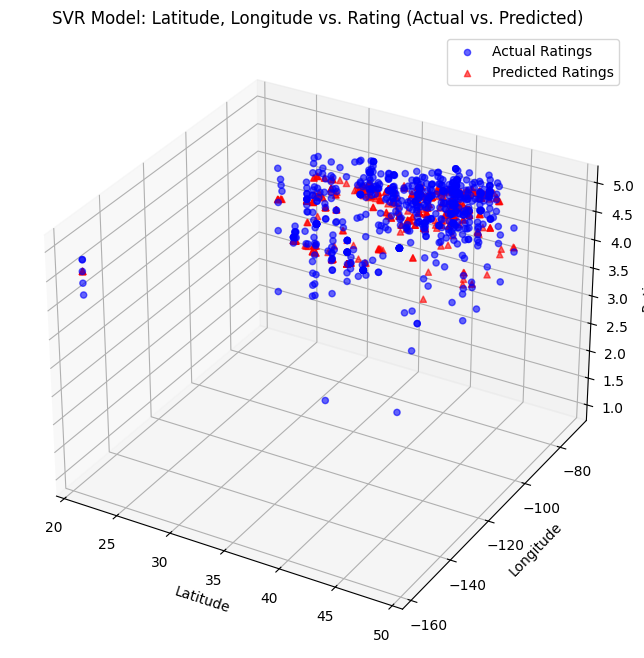

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test_svr[:, 0], X_test_svr[:, 1], y_test_svr, color='blue', label='Actual Ratings', alpha=0.6)

ax.scatter(X_test_svr[:, 0], X_test_svr[:, 1], y_pred_svr, color='red', marker='^', label='Predicted Ratings', alpha=0.6)

ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.set_zlabel("Rating")
ax.set_title("SVR Model: Latitude, Longitude vs. Rating (Actual vs. Predicted)")
ax.legend()

plt.show()

The above graph provides 3D scatter plot comparing actual and predicted ratings using a Support Vector Regressor (SVR) model. It has 3 axis where Latitude is plotted along the x-axis, Longitude is plotted along the y-axis and rating is plotted along the z-axis which is representing the customer ratings for various locations.Red triangles (predicted ratings) which are closely aligning  with the blue dots (actual ratings), it suggests that the model has a good fit.

# Explanation and Analysis for SVR for latitude and longitude v/s rating for "How does the geographical location (latitude/longitude) relate to customer ratings?"


Problem 1: How does the geographical location (latitude/longitude) relate to customer ratings?


Significance of using SVR:


SVR gives relationship between location and rating by capturing trends and smoothing the noise so that user can have broader understanding of location with resepct to ratings based on latitude/longitude. 

Justification for Choosing SVR:


SVR is highly effective for modeling complex relationship between input feature which is latitude and longitude and a continuous output variable which is ratings. The coordinates of latitude and longitude does not have linear relationship with rating and SVR is suitable choice for capturing non linear relationship. It has regularization parameter C which balances between maximizing  margin and minimizing  error and it is useful for data that may contain noise.It is also robust to outliers due to the presence of the margin parameter epsilon which is 0.2.

Tuning and Training:


RBF kernel capture non-linear relationships between latitude, longitude, and rating. This kernel can model complex interactions which may exist between geographical location(latitude/longitude) and ratings. For parameter tuning, regularization parameter C was set to 1.0 to balance  model’s sensitivity to errors. Epsilon margin tolerance was set to 0.2 which will helped in smoothing out the predictions by ignore errors within margin.

Effectiveness and Insights:

SVR provided a reasonably good fit to the data as indicated by a low Mean Squared Error (MSE) value of 0.22094076822200484.Mean Squared Error (MSE) Matrix was used to evaluate the accuracy of predictions, providing insight into average deviation from actual ratings.The 3D scatter plot shows actual vs. predicted ratings , helped in visualize the model's performance in capturing spatial patterns with respect to ratings.

Intelligence Gained:


SVR model allows for a deeper understanding of spatial patterns in customer ratings. For example, areas with higher ratings were clearly visible in the 3D plot, showing how certain geographical features may correlate with better customer experiences.

Ref :
https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/ 

In [13]:
#Using KNN for  finding/classifying the locations with more daily_avg_popularity during weekdays


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

df_cleaned['high_weekday_popularity'] = (df_cleaned['weekday_hours'] > df_cleaned['weekend_hours']).astype(int)

X_knn = df_cleaned[['latitude', 'longitude', 'weekday_hours', 'weekend_hours']].to_numpy()

noise = np.random.normal(0, 0.1, X_knn.shape)
X_knn += noise

y_knn = df_cleaned['high_weekday_popularity'].to_numpy()

knn_model = KNeighborsClassifier(n_neighbors=100) 
scores = cross_val_score(knn_model, X_knn, y_knn, cv=5)  

print("Cross-Validated Accuracy (with K=3 and Noise):", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())

Cross-Validated Accuracy (with K=3 and Noise): 0.8927294547636583
Standard Deviation of Accuracy: 0.11732941100193968


In [14]:
import folium

map_center = [df_cleaned['latitude'].mean(), df_cleaned['longitude'].mean()]
map_folium = folium.Map(location=map_center, zoom_start=6)

colors = {1: 'green', 0: 'orange'}

for idx, label in enumerate(y_knn):
    latitude = X_knn[idx, 0]
    longitude = X_knn[idx, 1]
    prediction = y_knn[idx]
    
    popup_text = f"Location: ({latitude:.4f}, {longitude:.4f})<br>Weekday Popularity: {'High' if prediction == 1 else 'Low'}"
    
    folium.CircleMarker(
        location=(latitude, longitude),
        radius=6,
        color=colors[prediction],
        fill=True,
        fill_color=colors[prediction],
        fill_opacity=0.7,
        tooltip=popup_text
    ).add_to(map_folium)

legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: 90px; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
    <h4>Weekday Popularity Legend</h4>
    <div><span style="color:green;">&#9679;</span> High Weekday Popularity</div>
    <div><span style="color:orange;">&#9679;</span> Low Weekday Popularity</div>
</div>
'''
map_folium.get_root().html.add_child(folium.Element(legend_html))

map_folium.save("Weekday_Popularity_Map.html")
map_folium

Above folium map illustrated high (green) and low (orange) weekday popular locations across the map, making it easy to identify regions with differing patterns in weekday popularity. This visualization provides areas which are more popular during the weekday.

# Explanation and Analysis for K-Nearest Neighbors (KNN) for finding/classifying the locations with more daily_avg_popularity during weekdays


Problem 2:Finding/ classifying the locations with more daily_avg_popularity during weekdays


Significance of using KNN:


KNN is particularly suitable for identifying and classifying patterns based on similarity. Here, KNN leverages the idea that locations with similar geographical and operational features are likely to have similar patterns in terms of weekday popularity.The predictions are based on the majority class of nearby neighbors. It offers a way to classify each location by considering the most common weekday popularity pattern in its neighborhood.

Justification for Choosing KNN:


KNN is particularly useful for making predictions based on similarity, which is staed above also amd  it relies on the average rating of nearby locations.Hence, KNN is well-suited for this classification task which groups locations based on similarities.It also ensures that predictions are based on broader patterns rather than  specific locations.

Tuning and Training:


Cross-Validation: A 5-fold cross-validation was performed to evaluate model stability across different subsets of the data. This cross-validation provided insights into the consistency of the KNN classifier and helped determine if n_neighbors=100 was appropriate.
Parameter Tuning (n_neighbors): Several values were tested for n_neighbors choosing 100  as it offered the best balance between generalization and capturing meaningful neighborhood patterns.

Effectiveness and Insights:

 KNN model provides a reasonable cross-validated accuracy of 0.8963598177999618 which effectively captured patterns in weekday popularity based on location. The standard deviation of accuracy was also low (which is 0.11476452201347076) shows consistency across different cross-validation folds.Below 2 Metrics were used:
Cross-Validated Accuracy: Cross-validation provided an average accuracy score and it helps in verify the model effectiveness across multiple data splits.
Standard Deviation of Accuracy: This metric offered insights into the model stability with a low standard deviation indicating reliable classification performance.

Intelligence Gained: 


By classifying locations with high or low weekday popularity, KNN model highlighted spatial trends. For example, clusters of high weekday popularity which is shown in green indicate areas which are more popular for travelers.Locations classified with low weekday popularity which is shown in orange can be use adjust  operating hours to attract more weekday visitors.



